In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from utils import (
    rcparams,
    to_GeV_per_cubic_femtometre,
    to_nucleons_per_cubic_femtometre,
    nsat
)
plt.rcParams.update(rcparams)

In [2]:
collated_eos_path = [
    'collated_eos.csv',
    'collated_np_all_post.csv', 
    '/home/isaac.legred/PTAnalysis/Analysis/collated_np_all_post.csv'
    ][0]

In [3]:
# Load the collated EOSs
collated_eos = pd.read_csv(collated_eos_path)

# The pre-computed weights of these EOSs
astro_weights = np.exp(collated_eos.logweight_total.values)

In [4]:
collated_ntov = to_nucleons_per_cubic_femtometre(collated_eos['rhoc(M@Mmax)'])

23732


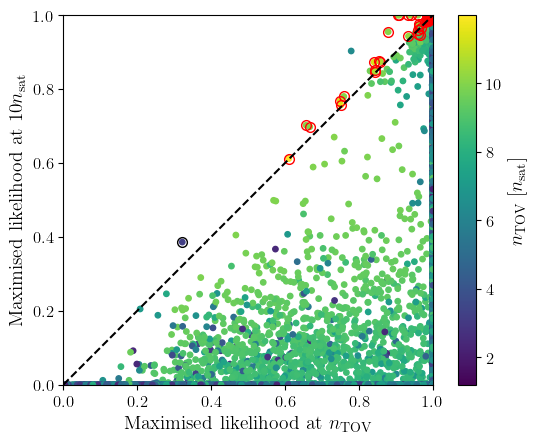

In [5]:
# pQCD likelihood scatter (Xmarg)

nterm_xy = ['ntov', '10nsat']
method = 'Xmarg'

# Remove large nTOV outliers for clarity
plot_mask = collated_ntov < 30*nsat

likelihood_x = np.loadtxt(f'weights/qcd_weights_{nterm_xy[0]}_{method}.dat')[plot_mask]
likelihood_y = np.loadtxt(f'weights/qcd_weights_{nterm_xy[1]}_{method}.dat')[plot_mask]

fig, ax = plt.subplots()
ax.set_aspect('equal')

im = ax.scatter(
    likelihood_x, 
    likelihood_y, 
    c=collated_ntov[plot_mask]/nsat, 
    cmap='viridis',
    s=15
    )

# Highlight EOSs that have nTOV > 10nsat
for ntov, x, y in zip(collated_ntov[plot_mask], likelihood_x, likelihood_y):
    if ntov > 10*nsat:
        ax.plot(x, y, marker='o', markersize=7, markerfacecolor='none', markeredgecolor='r')

# Identify outliers
for i, (ntov, x, y) in enumerate(zip(collated_ntov[plot_mask], likelihood_x, likelihood_y)):
    if (ntov < 5*nsat) & (y > x):
        ax.plot(x, y, marker='o', markersize=7, markerfacecolor='none', markeredgecolor='k')
        print(i)

cbar = fig.colorbar(im, ax=ax)
cbar.set_label(r'$n_\mathrm{TOV}$ [$n_\mathrm{sat}$]')

ax.set_xlabel('Maximised likelihood at $n_\mathrm{TOV}$')
ax.set_ylabel('Maximised likelihood at $10n_\mathrm{sat}$')

ax.plot([0, 1], [0, 1], 'k--')

ax.set_xlim(0, 1) # , 1)
ax.set_ylim(0, 1) # , 0.5)

fig.savefig(f'figures/likelihood/likelihood_scatter_{nterm_xy[0]}_{nterm_xy[1]}_{method}.pdf')

(0.9, 1.0)

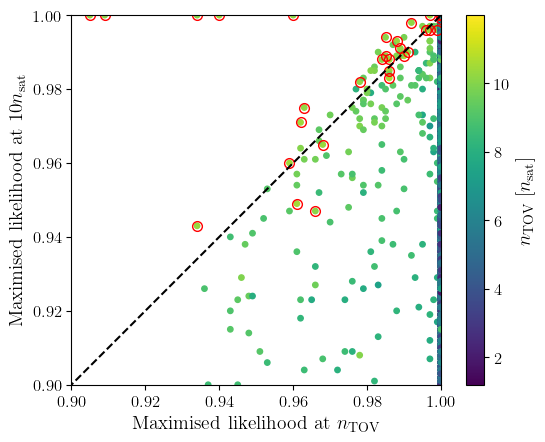

In [6]:
# pQCD likelihood scatter (Xmarg) (Zoomed)

nterm_xy = ['ntov', '10nsat']
method = 'Xmarg'

# Remove large nTOV outliers for clarity
plot_mask = collated_ntov < 30*nsat

likelihood_x = np.loadtxt(f'weights/qcd_weights_{nterm_xy[0]}_{method}.dat')[plot_mask]
likelihood_y = np.loadtxt(f'weights/qcd_weights_{nterm_xy[1]}_{method}.dat')[plot_mask]

fig, ax = plt.subplots()
ax.set_aspect('equal')

im = ax.scatter(
    likelihood_x, 
    likelihood_y, 
    c=collated_ntov[plot_mask]/nsat, 
    cmap='viridis',
    s=15
    )

for ntov, x, y in zip(collated_ntov[plot_mask], likelihood_x, likelihood_y):
    if ntov > 10*nsat:
        ax.plot(x, y, marker='o', markersize=7, markerfacecolor='none', markeredgecolor='r')

cbar = fig.colorbar(im, ax=ax)
cbar.set_label(r'$n_\mathrm{TOV}$ [$n_\mathrm{sat}$]')

ax.set_xlabel('Maximised likelihood at $n_\mathrm{TOV}$')
ax.set_ylabel('Maximised likelihood at $10n_\mathrm{sat}$')

ax.plot([0, 1], [0, 1], 'k--')

ax.set_xlim(0.9, 1) # , 1)
ax.set_ylim(0.9, 1) # , 0.5)

In [7]:
# Some example (mu [GeV], n [1/fm^3], p [GeV/fm^3]) values

chiEFT_values = {
    'soft': [0.966, 0.176, 2.163/1000],
    'stiff': [0.978, 0.176, 3.542/1000]
}

# Keys are different values for the renormalization scale parameter X
pQCD_values = {
    1: [2.6, 6.14, 2334/1000],
    2: [2.6, 6.47, 3823/1000],
    4: [2.6, 6.87, 4284/1000]
}

muL, nL, pL = chiEFT_values['stiff']
muH, nH, pH = pQCD_values[2]

In [8]:
# This EOS has a higher likelihood at 10nsat than at nTOV, despite nTOV being 
# lower
eos_index = 23732
eos = collated_eos[plot_mask].iloc[eos_index]
ntov = to_nucleons_per_cubic_femtometre(eos['rhoc(M@Mmax)'])

print(ntov/nsat)

3.2156415948680404


In [9]:
energy_density_at_ntov = np.loadtxt('quantities_at_ntov/energy_density.dat')[plot_mask][eos_index]
pressure_at_ntov = np.loadtxt('quantities_at_ntov/pressure.dat')[plot_mask][eos_index]

energy_density_at_10nsat = np.loadtxt('quantities_at_fixed_n/energy_density_10nsat.dat')[plot_mask][eos_index]
pressure_at_10nsat = np.loadtxt('quantities_at_fixed_n/pressure_10nsat.dat')[plot_mask][eos_index]

In [10]:
# First lets re-compute the likelihood

from qcd_likelihood import pQCD

def pQCD_likelihood(e, p, n, N=1000):

    weight = np.zeros(N)

    for i in range(N):
        
        X = np.random.uniform(np.log(1/2), np.log(2)) # Log-linear distribution
        pQCDX = pQCD(np.exp(X)) # Redefine class with new X
        
        # For each X assign 0 or 1 for given point
        weight[i] = int(pQCDX.constraints(e0=e,p0=p,n0=n))

    return weight.mean()

Text(0, 0.5, '$p$ [GeV/fm$^3$]')

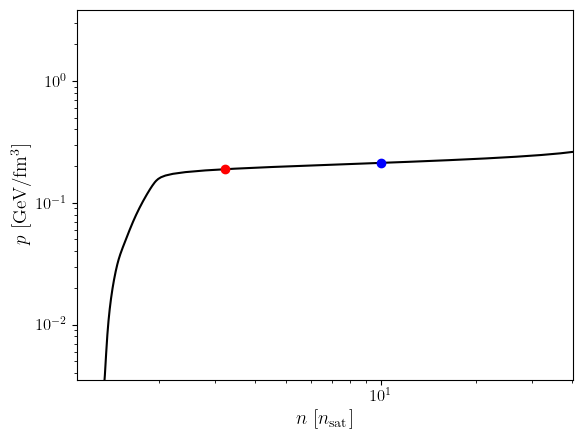

In [11]:
# Load the EOS
df = pd.read_csv(f'eos-draws/eos-draw-{int(eos.eos):06}.csv')

pressure = to_GeV_per_cubic_femtometre(df.pressurec2)
energy_density = to_GeV_per_cubic_femtometre(df.energy_densityc2)
number_density = to_nucleons_per_cubic_femtometre(df.baryon_density)

pressure_at_ntov = pressure[np.argmin(np.abs(number_density - ntov))]

fig, ax = plt.subplots()
ax.set_xscale('log')
ax.set_yscale('log')

ax.plot(number_density/nsat, pressure, c='k')
ax.plot(ntov/nsat, pressure_at_ntov, 'ro')
ax.plot(10, pressure_at_10nsat, 'bo')

ax.set_xlim(nL/nsat, nH/nsat)
ax.set_ylim(pL, pH)

ax.set_xlabel(r'$n\ [n_\mathrm{sat}]$')
ax.set_ylabel(r'$p$ [GeV/fm$^3$]')

In [12]:
repeats = 1000

likelihoods_at_ntov = []
likelihoods_at_10nsat = []
for _ in range(repeats):
    likelihoods_at_ntov.append(pQCD_likelihood(energy_density_at_ntov, pressure_at_ntov, ntov))
    likelihoods_at_10nsat.append(pQCD_likelihood(energy_density_at_10nsat, pressure_at_10nsat, 10*nsat))

(0.0, 1.0)

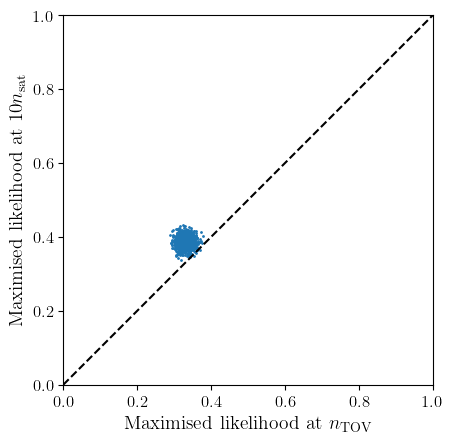

In [13]:
fig, ax = plt.subplots()
ax.set_aspect('equal')

im = ax.scatter(
    likelihoods_at_ntov, 
    likelihoods_at_10nsat, 
    s=1
    )

ax.set_xlabel('Maximised likelihood at $n_\mathrm{TOV}$')
ax.set_ylabel('Maximised likelihood at $10n_\mathrm{sat}$')

ax.plot([0, 1], [0, 1], 'k--')

ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

So maybe this is fine because of the spread?